In [55]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git 

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!cd

In [57]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle 
import pandas as pd
import random
np.random.seed(0)

In [0]:
#Open the pickled file and un-pickling them!
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
  
with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)
  
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
x_train, y_train = train_data['features'], train_data['labels']
 
x_valid, y_valid = valid_data['features'], valid_data['labels']

x_test, y_test = test_data['features'], test_data['labels']



In [0]:
#assert() used to check the initial condition if not true, throws an assertion error
assert(x_train.shape[0] == y_train.shape[0]),"The number of Images is not equal to number of Labels"
assert(x_test.shape[0] == y_test.shape[0]),"The number of Images is not equal to number of Labels"
assert(x_valid.shape[0] == y_valid.shape[0]),"The number of Images is not equal to number of Labels"
assert(x_train.shape[1:] == (32,32,3)),"The dimensions are not 32x3x3"

In [0]:
#Reading the training data
data =pd.read_csv('german-traffic-signs/signnames.csv')

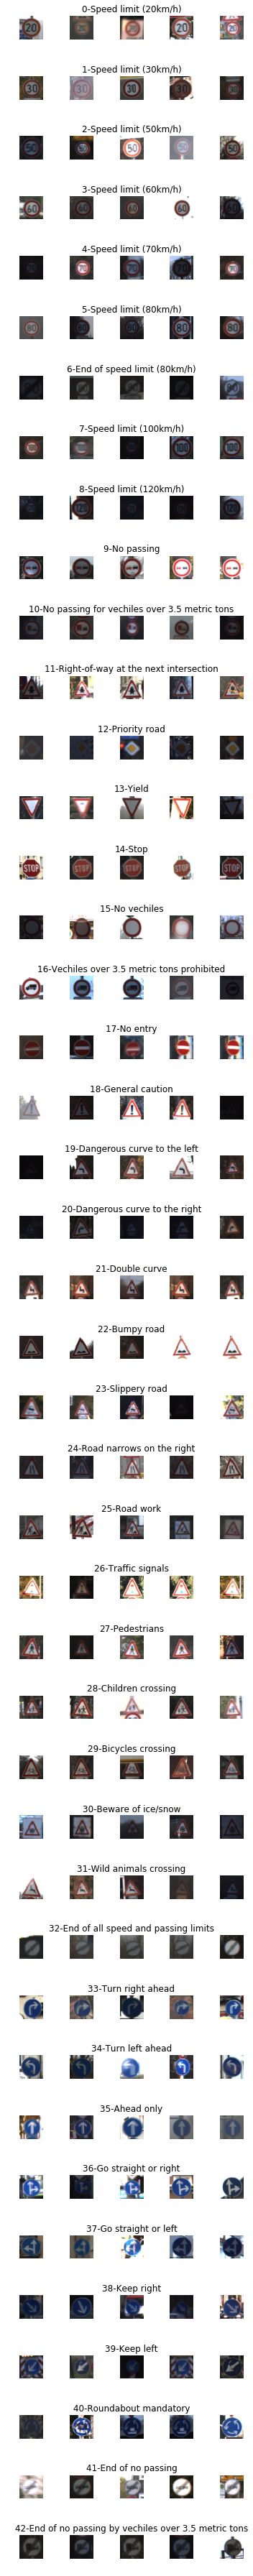

In [62]:
#Arrange the data
n_samples = []
coloumns = 5
n_classes = 43
fig, axs = plt.subplots(nrows = n_classes, ncols = coloumns, figsize = (5,50))
fig.tight_layout()
for i in range(coloumns):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected -1)),:,:], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i==2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            n_samples.append(len(x_selected))

(-0.5, 31.5, 31.5, -0.5)

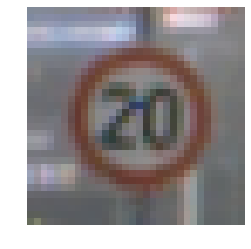

In [63]:
import cv2
plt.imshow(x_train[10000])
plt.axis("off")


(-0.5, 31.5, 31.5, -0.5)

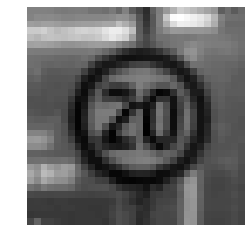

In [64]:
#processing the image
def grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray
gray_img = grayscale(x_train[10000])
plt.imshow(gray_img, cmap=plt.get_cmap('gray'))
plt.axis("off")

(-0.5, 31.5, 31.5, -0.5)

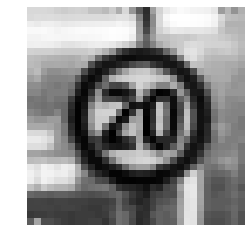

In [65]:
def equalize(image):
    eq_img = cv2.equalizeHist(image)
    return eq_img
img = equalize(gray_img)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis("off")

In [0]:
def pre_processing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

x_train = np.array (list(map(pre_processing, x_train)))
x_test = np.array (list(map(pre_processing, x_test)))
x_valid = np.array (list(map(pre_processing, x_valid)))



(4410, 32, 32)


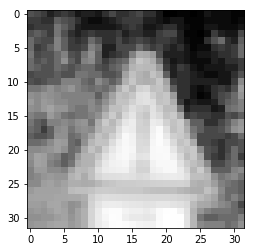

In [67]:
#Random training image 
plt.imshow(x_train[random.randint(0, len(x_train - 1))], cmap=plt.get_cmap('gray'))
print(x_valid.shape)

In [0]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_valid = x_valid.reshape(4410, 32, 32, 1)

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_valid = to_categorical(y_valid, 43)

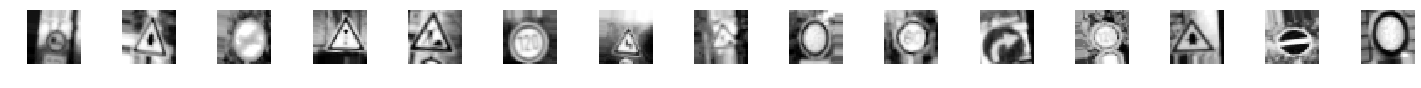

In [69]:
#Data Augmentation for increaing the accuracy
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 0.1, rotation_range = 10)
data_gen.fit(x_train)
batches = data_gen.flow(x_train, y_train, batch_size=20)
x_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize = (20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(x_batch[i].reshape(32,32), cmap=plt.get_cmap('gray'))
    axs[i].axis('off')

In [0]:
#LeNet based model 
def LenNet_model_mod():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation ='relu', strides = 1 , padding = 'valid'))
    model.add(Conv2D(60, (5,5), activation ='relu', strides = 1 , padding = 'valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Conv2D(30, (3,3), activation ='relu', strides = 1 , padding = 'valid'))
    model.add(Conv2D(30, (3,3), activation ='relu', strides = 1 , padding = 'valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    
    model.add(Flatten())
    
    
    
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [71]:
model = LenNet_model_mod()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 480)               0         
__________

In [72]:
#training the model
h= model.fit_generator(data_gen.flow(x_train, y_train, batch_size=50), steps_per_epoch=2000, epochs = 10, validation_data=(x_valid, y_valid), shuffle=1)


Epoch 1/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.8490 - acc: 0.7504 - val_loss: 0.0725 - val_acc: 0.9771
Epoch 2/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1999 - acc: 0.9368 - val_loss: 0.0732 - val_acc: 0.9771
Epoch 3/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1386 - acc: 0.9562 - val_loss: 0.0404 - val_acc: 0.9905
Epoch 4/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1098 - acc: 0.9658 - val_loss: 0.0666 - val_acc: 0.9848
Epoch 5/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.0915 - acc: 0.9717 - val_loss: 0.0337 - val_acc: 0.9923
Epoch 6/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.0787 - acc: 0.9763 - val_loss: 0.1049 - val_acc: 0.9803
Epoch 7/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.0738 - acc: 0.9769 - val_loss: 0.0414 - val_acc: 0.9866
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

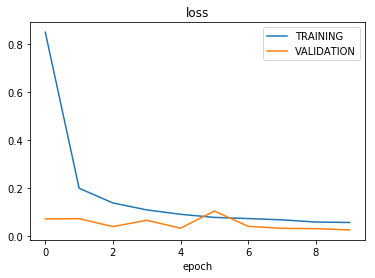

In [77]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['TRAINING', 'VALIDATION'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

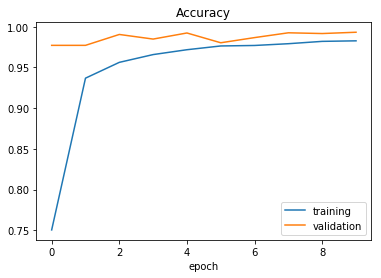

In [78]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [79]:
#Testing the model with test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:',score[1])

Test score: 0.12264579173994208
Test accuracy: 0.9717339667647203


(32, 32)
predicted sign: [23]


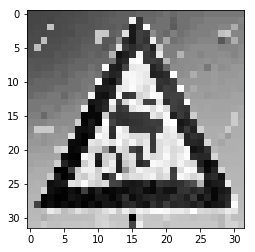

In [80]:
#Testing the images
#fetch image
 
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = pre_processing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))